# Using kallisto BUS to call cells

Dataset downloaded from https://www.ncbi.nlm.nih.gov/Traces/study/?acc=SRP127179

`Study: Cell hashing enable sample multiplexing, multiplet identification and super-loading on droplet-based single cell RNA-sequencing platforms`
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2895283

```
fasta files in GSM2895284:
ADT means AntiboDy Tag (used in the citeseq epitope mapping method)
HTO means Hash Tag Oligo (used in cell hashing multiplexing method)
RNA means the actual transcript reads, which must be cross referenced with the ADT and HTO data

GSM2895284: Hashtag-ADT; Homo sapiens; RNA-Seq(SRR8281308)
GSM2895283: Hashtag-HTO; Homo sapiens; RNA-Seq(SRR8281307)
GSM2895282: Hashtag-RNA; Homo sapiens; RNA-Seq(SRR8281306)
    
```

To download it we use fasterq-dump is a folder named `data`, it takes a while because the 3 datasets (each containing read1 and read 2) are big.
```
SRR8281306 ~ 253GB after unzip
SRR8281307 ~ 30GB after unzip
SRR8281308 ~ 35GB after unzip
```

Instructions on installing `fasterq-dump`: https://github.com/ncbi/sra-tools/wiki/HowTo:-fasterq-dump


To download, `cd` to the data folder and just do on your terminal

```
fasterq-dump SRR8281308
fasterq-dump SRR8281307
fasterq-dump SRR8281306
```




bioRxiv preprint:
Cell "hashing" with barcoded antibodies enables multiplexing and doublet detection for single cell genomics
https://www.biorxiv.org/content/early/2017/12/21/237693.full.pdf+html

Published on Genome Biology: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1603-1




Oligonucleotide sequences
The following are the oligonucleotide sequences:
    
```
Hashtag oligo: GTGACTGGAGTTCAGACGTGTGCTCTTCCGATCTxxxxxxxxxxxxBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA*A*A

HTO additive: GTGACTGGAGTTCAGACGTGTGCTC

ADT additive: CCTTGGCACCCGAGAATTCC

SI-PCR: AATGATACGGCGACCACCGAGATCTACACTCTTTCCCTACACGACGC*T*C

RPI-x: CAAGCAGAAGACGGCATACGAGATxxxxxxxxGTGACTGGAGTTCCTTGGCACCCGAGAATTCCA

D7xx_s: CAAGCAGAAGACGGCATACGAGATxxxxxxxxGTGACTGGAGTTCAGACGTGTGC
    
x: Barcode or index sequence

B: T,G,C, not A

*: Phosphorothioate bond
```

In [24]:
from collections import OrderedDict
from Bio import SeqIO
import os

In [146]:
work_folder = '/home/munfred/hashing/'
write_folder = os.path.join(work_folder, 'write')
kallisto_output_folder = os.path.join(work_folder, 'kallisto_HTO_output')
data_folder = os.path.join(work_folder, 'data')

In [2]:
## set parameters - below are parameters for 10x 3' v2 chemistry
## The Cell Hashing method uses tags of length 12, we included the contant T in the beginning to make it lenght 13
cell_barcode_length = 16
UMI_length = 10
sample_tag_length=13

In [3]:
"""
First, generate a database for all sample tags and their H=1 hamming space.
Include an extra C or CAG to the 8-bp barcode to get an odd k-mer length.
"""

"parse the tags file and output the set of tag sequences"

def parse_tags(filename):
    odict = OrderedDict()
    print('Read the following tags:')
    for record in SeqIO.parse(filename, "fasta"):
        #odict[row[0].encode('utf-8')] = row[1]
        counter=0
        print(record.seq)
        odict[record.name] = str(record.seq)[:sample_tag_length]
        for pos in range(sample_tag_length):
            if pos == sample_tag_length -1: break
            letter =str(record.seq)[pos]
            barcode=list(str(record.seq)[:+sample_tag_length])
            if letter=='A':
                barcode[pos]='T'
                odict[record.name+'-'+str(pos)+'-1'] = "".join(barcode)
                barcode[pos]='G'
                odict[record.name+'-'+str(pos)+'-2'] = "".join(barcode)
                barcode[pos]='C'
                odict[record.name+'-'+str(pos)+'-3'] = "".join(barcode)
            elif letter=='G':
                barcode[pos]='T'
                odict[record.name+'-'+str(pos)+'-1'] = "".join(barcode)
                barcode[pos]='A'
                odict[record.name+'-'+str(pos)+'-2'] = "".join(barcode)
                barcode[pos]='C'
                odict[record.name+'-'+str(pos)+'-3'] = "".join(barcode)
            elif letter=='C':
                barcode[pos]='T'
                odict[record.name+'-'+str(pos)+'-1'] = "".join(barcode)
                barcode[pos]='G'
                odict[record.name+'-'+str(pos)+'-2'] = "".join(barcode)
                barcode[pos]='A'
                odict[record.name+'-'+str(pos)+'-3'] = "".join(barcode)
            else:
                barcode[pos]='A'
                odict[record.name+'-'+str(pos)+'-1'] = "".join(barcode)
                barcode[pos]='G'
                odict[record.name+'-'+str(pos)+'-2'] = "".join(barcode)
                barcode[pos]='C'
                odict[record.name+'-'+str(pos)+'-3'] = "".join(barcode)
                
    return odict

In [9]:
tags = work_folder + "tags/hashing_tags_len13.fasta"
tag_map=parse_tags(tags)

Read the following tags:
AGGACCATCCAAT
ACATGTTACCGTT
AGCTTACTATCCT
TCGATAATGCGAT
GAGGCTGAGCTAT
GTGTGACGTATTT
ACTGTCTAACGGT
TATCACATCGGTT
AGGACCATCCAAC
ACATGTTACCGTC
AGCTTACTATCCC
TCGATAATGCGAC
GAGGCTGAGCTAC
GTGTGACGTATTC
ACTGTCTAACGGC
TATCACATCGGTC
AGGACCATCCAAG
ACATGTTACCGTG
AGCTTACTATCCG
TCGATAATGCGAG
GAGGCTGAGCTAG
GTGTGACGTATTG
ACTGTCTAACGGG
TATCACATCGGTG


In [10]:
len(tag_map)

888

In [11]:
# take a look at the tag dictionary, which includes 1 hamming distance versions of all valid tags
list(tag_map.items())[:50]

[('hashtagA-T', 'AGGACCATCCAAT'),
 ('hashtagA-T-0-1', 'TGGACCATCCAAT'),
 ('hashtagA-T-0-2', 'GGGACCATCCAAT'),
 ('hashtagA-T-0-3', 'CGGACCATCCAAT'),
 ('hashtagA-T-1-1', 'ATGACCATCCAAT'),
 ('hashtagA-T-1-2', 'AAGACCATCCAAT'),
 ('hashtagA-T-1-3', 'ACGACCATCCAAT'),
 ('hashtagA-T-2-1', 'AGTACCATCCAAT'),
 ('hashtagA-T-2-2', 'AGAACCATCCAAT'),
 ('hashtagA-T-2-3', 'AGCACCATCCAAT'),
 ('hashtagA-T-3-1', 'AGGTCCATCCAAT'),
 ('hashtagA-T-3-2', 'AGGGCCATCCAAT'),
 ('hashtagA-T-3-3', 'AGGCCCATCCAAT'),
 ('hashtagA-T-4-1', 'AGGATCATCCAAT'),
 ('hashtagA-T-4-2', 'AGGAGCATCCAAT'),
 ('hashtagA-T-4-3', 'AGGAACATCCAAT'),
 ('hashtagA-T-5-1', 'AGGACTATCCAAT'),
 ('hashtagA-T-5-2', 'AGGACGATCCAAT'),
 ('hashtagA-T-5-3', 'AGGACAATCCAAT'),
 ('hashtagA-T-6-1', 'AGGACCTTCCAAT'),
 ('hashtagA-T-6-2', 'AGGACCGTCCAAT'),
 ('hashtagA-T-6-3', 'AGGACCCTCCAAT'),
 ('hashtagA-T-7-1', 'AGGACCAACCAAT'),
 ('hashtagA-T-7-2', 'AGGACCAGCCAAT'),
 ('hashtagA-T-7-3', 'AGGACCACCCAAT'),
 ('hashtagA-T-8-1', 'AGGACCATTCAAT'),
 ('hashtagA-T-8-

In [95]:
#Write the list of barcodes as a fasta, then make a kallisto index
tagmap_filename = "hash_tagmap_len13.fa"
if not os.path.exists(write_folder): os.makedirs(write_folder)
    
  

In [27]:
tagmap_file = open(os.path.join(write_folder,tagmap_filename) , "w+")
for i in list(tag_map.keys()):
    tagmap_file.write(">" + i + "\n" +tag_map[i] + "\n")
tagmap_file.close()

# Make a kallisto index with your fasta

Notice that the `!` starting the line below means it's a bash command

Here we take advantadge of being able to call python variable within the bash command

Those are the variables enclosed by `{}`

In this example `{tagmap_file}` becomes `./write/hash_tagmap_len13.fa`

And `{tagmap_file}.idx` becomes `./write/hash_tagmap_len13.fa.idx`, our index file

In [28]:
!kallisto index -i {write_folder + tagmap_filename}.idx -k 13 {write_folder + tagmap_filename}


[build] loading fasta file /home/munfred/hashing/write/hash_tagmap_len13.fa
[build] k-mer length: 13
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 888 contigs and contains 888 k-mers 



In [29]:
!kallisto inspect {write_folder + tagmap_filename}.idx

[index] k-mer length: 13
[index] number of targets: 888
[index] number of k-mers: 888
[index] number of equivalence classes: 888
#[inspect] Index version number = 10
#[inspect] k = 13
#[inspect] number of targets = 888
#[inspect] number of equivalence classes = 888
#[inspect] number of contigs = 888
#[inspect] Number of k-mers in index = 888
#EC.size	Num.targets
1	888


#EC.size	Num.kmers
1	888


# run kallisto bus with hash index against HTO and ADT fastqs

In [22]:
!kallisto bus

kallisto 0.45.0
Generates BUS files for single cell sequencing

Usage: kallisto bus [arguments] FASTQ-files

Required arguments:
-i, --index=STRING            Filename for the kallisto index to be used for
                              pseudoalignment
-o, --output-dir=STRING       Directory to write output to
-x, --technology=STRING       Single cell technology used 

Optional arguments:
-l, --list                    List all single cell technologies supported
-t, --threads=INT             Number of threads to use (default: 1)


In [23]:
!kallisto bus --list


List of supported single cell technologies

short name       description
----------       -----------
10Xv1            10X chemistry version 1
10Xv2            10X chemistry verison 2
DropSeq          DropSeq
inDrop           inDrop
CELSeq           CEL-Seq
CELSeq2          CEL-Seq version 2
SCRBSeq          SCRB-Seq



## HTO (cell hashing)sample aligned with HTO tag index
We expect good alignment

In [30]:
tagmap_filename

'hash_tagmap_len13.fa'

In [47]:
!kallisto bus -i {os.path.join(write_folder, tagmap_filename)}.idx -o {kallisto_output_folder} -x 10xv2 -t 40 \
{os.path.join(data_folder,'SRR8281307_1.fastq')} {os.path.join(data_folder, 'SRR8281307_2.fastq')}



[index] k-mer length: 13
[index] number of targets: 888
[index] number of k-mers: 888
[index] number of equivalence classes: 888
[quant] will process sample 1: /home/munfred/hashing/data/SRR8281307_1.fastq
                               /home/munfred/hashing/data/SRR8281307_2.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 74,219,921 reads, 71,707,467 reads pseudoaligned


# Process bus file

In [53]:
kallisto_output_folder

'/home/munfred/hashing/kallisto_HTO_output'

In [54]:
#sort bus file
!bustools sort -o {os.path.join(kallisto_output_folder,'output_sorted.bus')} {os.path.join(kallisto_output_folder,'output.bus')}

Read in 71707467 number of busrecords
All sorted


In [55]:
# convert the sorted busfile to txt
!bustools text -o {os.path.join(kallisto_output_folder,'output_sorted.txt')} {os.path.join(kallisto_output_folder,'output_sorted.bus')}

Read in 21096127 number of busrecords


# Collapse the tags on the `output_sorted.txt` bus file

In [56]:
import pandas as pd
import copy
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import scipy
import numpy as np
import anndata
%matplotlib inline

In [69]:
data = pd.read_csv(os.path.join(kallisto_output_folder,'output_sorted.txt'), delimiter='\t', header=None, names = ['barcode', 'umi', 'tag', 'multiplicity'])

data.head()

,barcode,umi,tag,multiplicity
0,AAAAAAAAAAAAAAAA,AATAAACTTT,0,1
1,AAAAAAAAAACGAAAA,AAAAAAAAAA,259,1
2,AAAAAAAAACTGAACG,CGACTCTATA,74,1
3,AAAAAAAAGGCGAGGC,TGGCGTACCA,518,1
4,AAAAAAAAGTTCGGCG,GGCCAAAAAA,222,1


## First sanity check: plot uncorreceted hashtag abundances

We see 8 peaks corresponding to the expected hashed A-H, and several little peaks corresponding to the reads that had one base wrong

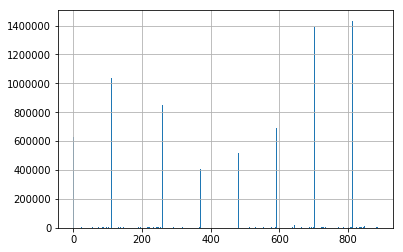

In [58]:
data['tag'].hist(bins = 888)


In [70]:
# put tagmap in a dataframe
tag_df = pd.DataFrame.from_dict(tag_map, orient = 'index').reset_index()
tag_df.columns=['tagname','tagseq']
tag_df['hashtag'] = tag_df['tagname'].str.slice(start=0,stop=8)
tag_df.head()


,tagname,tagseq,hashtag
0,hashtagA-T,AGGACCATCCAAT,hashtagA
1,hashtagA-T-0-1,TGGACCATCCAAT,hashtagA
2,hashtagA-T-0-2,GGGACCATCCAAT,hashtagA
3,hashtagA-T-0-3,CGGACCATCCAAT,hashtagA
4,hashtagA-T-1-1,ATGACCATCCAAT,hashtagA


In [71]:
# maps the tags equivalence classes (which should have a one to one correspondence) to the correct tag
data['tag']= data['tag'].map(tag_df['hashtag'])
data.head()

,barcode,umi,tag,multiplicity
0,AAAAAAAAAAAAAAAA,AATAAACTTT,hashtagA,1
1,AAAAAAAAAACGAAAA,AAAAAAAAAA,hashtagH,1
2,AAAAAAAAACTGAACG,CGACTCTATA,hashtagC,1
3,AAAAAAAAGGCGAGGC,TGGCGTACCA,hashtagG,1
4,AAAAAAAAGTTCGGCG,GGCCAAAAAA,hashtagG,1


In [72]:
# check tag abundances
data['tag'].value_counts()

hashtagG    3620200
hashtagD    3304874
hashtagB    2836998
hashtagF    2575345
hashtagH    2522968
hashtagE    2322790
hashtagC    2019601
hashtagA    1893351
Name: tag, dtype: int64

# Export .mtx matrix market file

In [73]:
data.head()

,barcode,umi,tag,multiplicity
0,AAAAAAAAAAAAAAAA,AATAAACTTT,hashtagA,1
1,AAAAAAAAAACGAAAA,AAAAAAAAAA,hashtagH,1
2,AAAAAAAAACTGAACG,CGACTCTATA,hashtagC,1
3,AAAAAAAAGGCGAGGC,TGGCGTACCA,hashtagG,1
4,AAAAAAAAGTTCGGCG,GGCCAAAAAA,hashtagG,1


In [81]:
print('Counting UMIs...')
counted_data = data.groupby(['barcode', 'tag'])['umi'].count().reset_index()
counted_data.rename(columns={'umi':'umi_counts'}, inplace = True)
print('Counted', len(counted_data), 'unique UMIs')
counted_data.head()

Counting UMIs...
Counted 2094925 unique UMIs


,barcode,tag,umi_counts
0,AAAAAAAAAAAAAAAA,hashtagA,1
1,AAAAAAAAAACGAAAA,hashtagH,1
2,AAAAAAAAACTGAACG,hashtagC,1
3,AAAAAAAAGGCGAGGC,hashtagG,1
4,AAAAAAAAGTTCGGCG,hashtagG,1


In [91]:
print('Counting unique cell barcodes...')
barcode_counted_data = counted_data.groupby(['tag'])['barcode'].count().reset_index()
barcode_counted_data.rename(columns={'barcode':'barcode_counts'}, inplace = True)
print('Counted', barcode_counted_data['barcode_counts'].sum(), 'unique cell barcodes')
barcode_counted_data

Counting unique cell barcodes...
Counted 2094925 unique cell barcodes


,tag,barcode_counts
0,hashtagA,205712
1,hashtagB,262168
2,hashtagC,227460
3,hashtagD,300741
4,hashtagE,240913
5,hashtagF,259452
6,hashtagG,343616
7,hashtagH,254863


In [92]:
# encode barcode, umi and hashtags, which are strings, as ints
le_barcode = LabelEncoder()
barcode_idx =le_barcode.fit_transform(counted_data['barcode'].values)
print('Barcode index shape:', barcode_idx.shape)

le_umi = LabelEncoder()
umi_idx = le_umi.fit_transform(counted_data['umi_counts'].values)
print('UMI index shape:', umi_idx.shape)

le_tag = LabelEncoder()
tag_idx = le_tag.fit_transform(counted_data['tag'].values)
print('Tag index shape:', tag_idx.shape)

Barcode index shape: (2094925,)
UMI index shape: (2094925,)
Tag index shape: (2094925,)


In [93]:
# put the counts table into a sparse matrix
x = scipy.sparse.csr_matrix((counted_data['umi_counts'].values,(barcode_idx,tag_idx)))

In [104]:
# write everything to file
scipy.io.mmwrite(os.path.join(write_folder,'HTO_hashtag_counts.mtx'),x)
pd.DataFrame(le_tag.classes_).to_csv(os.path.join(write_folder,'HTO_mtx_hashtags.csv'), index = False, header = False)
pd.DataFrame(le_barcode.classes_).to_csv(os.path.join(write_folder,'HTO_mtx_cell_barcodes.csv'), index = False, header = False)

# Import the mtx using anndata

In [109]:
adata = anndata.AnnData(scipy.io.mmread(os.path.join(write_folder,'HTO_hashtag_counts.mtx')))

In [119]:
pd.read_csv(os.path.join(write_folder,'HTO_mtx_cell_barcodes.csv'),header=None, names=['hashtags']).shape

(1376870, 1)

In [120]:
pd.read_csv(os.path.join(write_folder,'HTO_mtx_cell_barcodes.csv'),header=None, names=['cell_barcodes']).shape

(1376870, 1)

In [121]:
adata.obs = pd.read_csv(os.path.join(write_folder,'HTO_mtx_cell_barcodes.csv'),header=None, names=['cell_barcodes'])
adata.var = pd.read_csv(os.path.join(write_folder,'HTO_mtx_hashtags.csv'),header=None, names=['hashtags'])

In [122]:
sorted_HTO = np.array(copy.deepcopy(adata.X.sum(axis=0)))
sorted_HTO

array([[1893351., 2836998., 2019601., 3304874., 2322790., 2575345.,
        3620200., 2522968.]], dtype=float32)

In [128]:
import scanpy
import scanpy.api as sc


In [133]:
sc.tl.pca(adata, svd_solver='arpack')


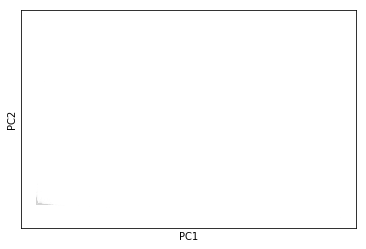

In [134]:
sc.pl.pca(adata)


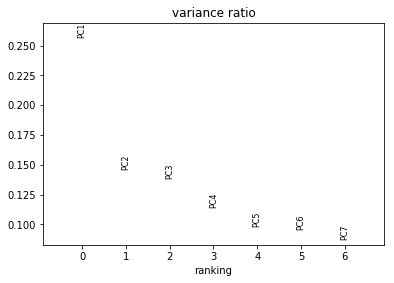

In [136]:
scanpy.api.pl.pca_variance_ratio(adata)